# Deep Learning for Computer Vision:  HW 2


## Computer Science: COMS W 4995 007


## Due: October 9, 2019

#### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu or leaky ReLu. For the loss function use a softplus on a linear output layer as we did in class.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels. 

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units effects the solution.

e) Try choosing you own loss function (without asking me or the TAs what you should choose), repeating (d).

f) Now try with three inputs, generating your own training and validation data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisey as before.) Use softplus loss. Do not try to show the decision regions, instead generate a validation set in the same manner as the training set, classify the samples, and compute the classification accuracy.

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 85%, e=10%, f=5%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



Let's start by importing some libraries.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

Let's make up some noisy XOR data.

In [2]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,0.757266,-0.183689,1.0
1,0.988629,0.073111,1.0
2,0.087107,0.163662,0.0
3,-0.112203,1.038005,1.0
4,1.007118,0.815554,0.0


Let's message this data into a numpy format.

In [3]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [4]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

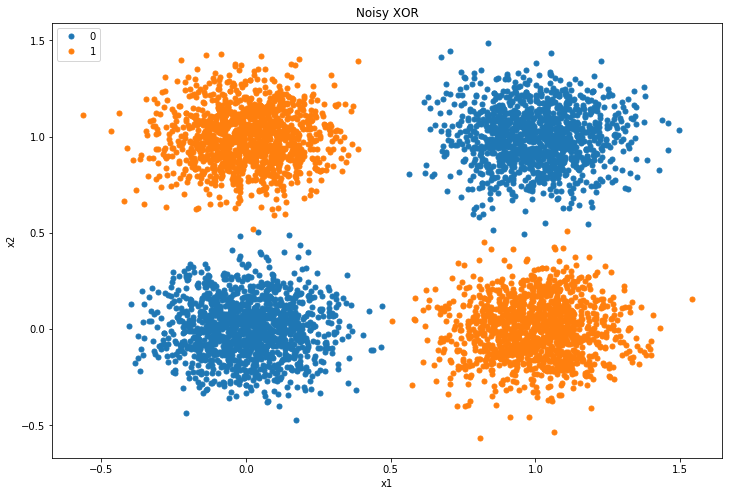

In [5]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers and we are off...

In [86]:
# TO DO: remove outputs/functions which are not needed/can be combined
# Forward Propogation functions
# Hidden layer output
def get_hidden_layer_output(input_matrix):
    h = np.zeros((len(input_matrix), 1))
    for i in range(len(h)):
        h[i] = max(0, input_matrix[i])
    return h

# W should be 2 by m matrix, where m is the number of units in the hidden layer
# x should be one data point of 2 by 1 and c is the bias of m by 1
# Output: m by 1 array
def get_first_layer_output(W, x, c):
    W_T = np.transpose(W)
    u_1 = np.matmul(W_T, x)
    u_2 = u_1 + c
    return u_2

# Input h: m by 1 array
# Weights w: m by 1 array 
# Bias b: scalar
# Output: Scalar value
def get_last_layer_output(w, h, b):
    w_T = np.transpose(w)
    u_3 = np.matmul(w_T, h)
    z = u_3 + b
    return z

def get_loss_layer_output(y, z):
    softplus_input = (1 - 2*y)*z
    loss = np.log10(1 + np.exp(softplus_input))
    return [softplus_input, loss]

In [87]:
# Backpropogation functions
def get_loss_layer_deriv(softplus_input):
    loss_layer_deriv = 1/(1 + np.exp(-1 * softplus_input))
    return loss_layer_deriv

# Partial derivative of loss layer wrt z = partial derivative of loss layer wrt to b
def get_last_layer_deriv(loss_layer_deriv, y):
    partial_deriv_wrt_z = loss_layer_deriv*(1 - (2*y))
    return partial_deriv_wrt_z

# Scalar * (m by 1) array
def get_w_deriv(partial_deriv_wrt_z, h):
    partial_deriv_wrt_w = np.multiply(partial_deriv_wrt_z, h)
    return partial_deriv_wrt_w

# Scalar * (m by 1) array
def get_h_deriv(partial_deriv_wrt_z, w):
    partial_deriv_wrt_h = np.multiply(partial_deriv_wrt_z, w)
    return partial_deriv_wrt_h

# Should be (m by m) * (m by 1) proucing m by 1
def get_b_deriv(partial_deriv_wrt_h, u_2):
    f_u_2 = np.zeros((len(u_2), len(u_2)))
    for i in range(len(u_2)):
        if u_2[i] <= 0:
            f_u_2[i, i] = 0
        else:
            f_u_2[i, i] = 1
    partial_deriv_wrt_c = np.dot(f_u_2, partial_deriv_wrt_h)
    return partial_deriv_wrt_c

# Should produce an 2 by m matrix at the end
def get_W_deriv(data_point, partial_deriv_wrt_c):
    partial_deriv_wrt_W = data_point * np.transpose(partial_deriv_wrt_c)
    return partial_deriv_wrt_W

In [88]:
# Train Network using the data present above
# Should provide updated w values (with b and c embedded)
# Define a learning rate and upate w, W, b an c to get final values 
# Need learning rate which is either the same or smaller after some number of steps
# How many steps should the algorithm run for?


In [96]:
# m = number of units in hidden layer
# Start with m = 2
m = 2

# Initialize values; should they be set to 0?
W = np.zeros((2, m))
W[0, 0] = 4
W[0, 1] = 3
W[1, 0] = 4

w = np.zeros((m, 1))
w[0, 0] = 4
c = np.zeros((m, 1))
b = 0

# number of iterations
# Use accuracy metric?
iters = 100000

# Learning rate
# Should this be decreasing with x number of iterations
lr = 0.01

for i in range(iters):
    # Use a batch size of 1; select data point from training data
    i = np.random.randint(0, len(X) - 1)
    data_point = X[i].T
    true_y = y[i]
    
    # Push data point through
    u_2 = get_first_layer_output(W, data_point, c)
    h = get_hidden_layer_output(u_2)
    z = get_last_layer_output(w, h, b)
    # Use the loss to determine when we're done?
    [softplus_input, loss] = get_loss_layer_output(true_y, z)
    
    #Find gradients
    loss_layer_deriv = get_loss_layer_deriv(softplus_input)
    # Equal to partial derivative wrt b
    partial_deriv_wrt_z = get_last_layer_deriv(loss_layer_deriv, true_y)
    partial_deriv_wrt_w = get_w_deriv(partial_deriv_wrt_z, h)
    partial_deriv_wrt_h = get_h_deriv(partial_deriv_wrt_z, w)
    partial_deriv_wrt_c = get_b_deriv(partial_deriv_wrt_h, u_2)
    partial_deriv_wrt_W = get_W_deriv(data_point, partial_deriv_wrt_c)

    # Update weights and constants
    W = W - lr*partial_deriv_wrt_W 
    b = b - lr*partial_deriv_wrt_z
    w = w - lr*partial_deriv_wrt_w
    c = c - lr*partial_deriv_wrt_c

print(W)
print(b)
print(w)
print(c)

[[4.1595546  4.93488351]
 [3.98662213 4.85318842]]
[[-5.16600586]]
[[ 4.16322545]
 [-7.71470119]]
[[-0.59979076]
 [-5.11247586]]
